# Autoregressive Conditional Heteroskedasticity Model - ARCH

Most common model in measuring volatility 

Simple ARCH model:

Var(y<sub>t</sub> | y<sub>t - 1</sub>) = α<sub>0</sub> + α<sub>1</sub> * ε<sup>2</sup><sub>t - 1</sub>


Var(y<sub>t</sub> | y<sub>t - 1</sub>) - conditional variance, relying on past values = σ<sup>2</sup><sub>t</sub>

α<sub>0</sub> - constant factor 

α<sub>1</sub> - coefficient associated with the first term

ε<sup>2</sup><sub>t - 1</sub> - squared value of the residual epsilon for the previous period

σ<sup>2</sup><sub>t</sub> = α<sub>0</sub> + α<sub>1</sub> * ε<sup>2</sup><sub>t - 1</sub>

σ<sup>2</sup><sub>t</sub> = α<sub>0</sub> + α<sub>1</sub> * ε<sup>2</sup><sub>t - 1</sub> + α<sub>2</sub> * ε<sup>2</sup><sub>t - 2</sub> + ... + α<sub>q</sub> * ε<sup>2</sup><sub>t - q</sub>

## Volatility 

Numeric measurement of uncertainty

Often not directly observable

Evolves continuously

Doesn't go off to infinity

### Detailed look ta ARCH model

r<sub>t</sub> = μ<sub>t</sub> + ε<sub>t</sub>

ε<sub>t</sub> - residual values left after estimating the coefficients

μ<sub>t</sub> - mean, or a function of past values and past errors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set() 

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse
#del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [4]:
def LLR_test(mod_1, mod_2, DF=1): # models we want to compare and degrees of freedom
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  LR = (2 * (L2 - L1))
  p = chi2.sf(LR, DF).round(3)
  return p

### Creating returns

In [5]:
df['returns'] = df.market_value.pct_change(1) * 100

<ipython-input-5-3660ab611850>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1) * 100


### Creating squared returns

In [6]:
df['sq_returns'] = df.returns.mul(df.returns)

<ipython-input-6-e7bdc4882207>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sq_returns'] = df.returns.mul(df.returns)


### Returns vs Squared returns

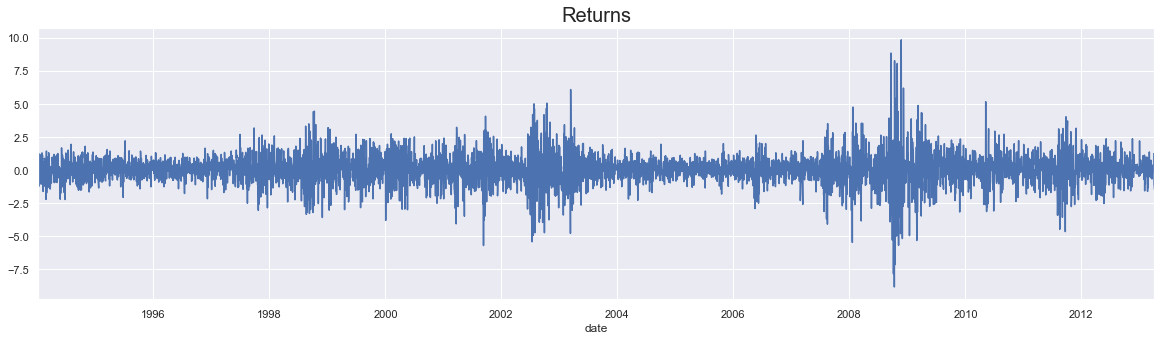

In [7]:
df.returns.plot(figsize=(20, 5))
plt.title('Returns', size=20)
plt.show()

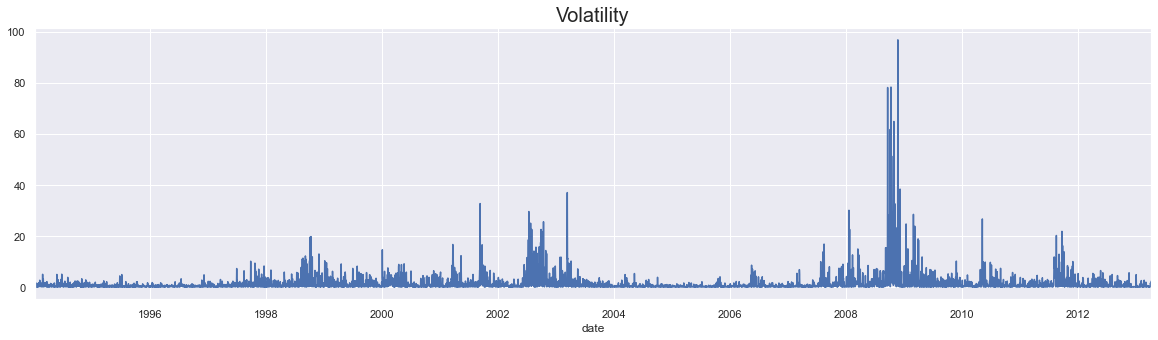

In [8]:
df.sq_returns.plot(figsize=(20, 5))
plt.title('Volatility', size=20)
plt.show()

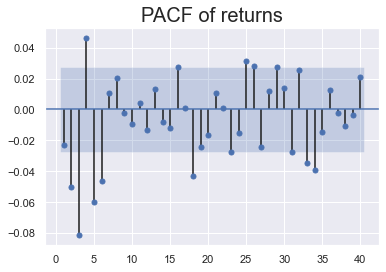

In [9]:
sgt.plot_pacf(df.returns[1:], lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF of returns', size=20)
plt.show()

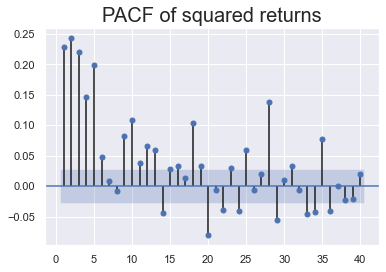

In [10]:
sgt.plot_pacf(df.sq_returns[1:], lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF of squared returns', size=20)
plt.show()

### arch_model() method

1. define a model
2. fit it to the data set
3. display its table of summarized statistics

In [11]:
from arch import arch_model

In [14]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq=2)
results_arch_1.summary()

# mean model is constant, rather than moving
# volatility model is GARCH
# distribution of residuals is normal
# DF model - number of coefficients we are trying to estimate

Iteration:      2,   Func. Count:     15,   Neg. LLF: 2701100877.2298183
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.035884053223
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.41810662336
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879267693578
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478416067
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189876
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5019
Time:                        18:11:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## Simple ARCH(1)

In [15]:
model_arch_1 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=1)
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

# finished in 6 iterations which means specifications were loos enough and that our model is light and doesn't take too long to compute

# R-squared is a useful measurement but not for ARCH models

# Even the simplest ARCH model yields a better estimate than the complex multi-lag ARIMA models

# If a p-value has a number <-2 after the exponential, it is significantly different from 0

# All three coefficients turn out to be significant

# Log-likelihood is higher than that of any of the ARIMAX models we showed

# ARCH can only be used to predict future variance rather than future returns

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29071.830522657772
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12040.742295031192
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7809.722526011103
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7660.088789374433
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.08878204096
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7660.088782040992
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.08878204096
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5019
Time:                        18:12:52   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [16]:
model_arch_zero = arch_model(df.returns[1:], mean='Zero', vol='ARCH', p=1)
results_arch_zero = model_arch_zero.fit()
results_arch_zero.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11616.48652979687
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7814.993386617751
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7662.9347358708
Iteration:      4,   Func. Count:     18,   Neg. LLF: 7662.934731760461
Iteration:      5,   Func. Count:     20,   Neg. LLF: 7662.9347317604725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7662.934731760461
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7662.93
Distribution:                  Normal   AIC:                           15329.9
Method:            Maximum Likelihood   BIC:                           15342.9
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5020
Time:                        19:00:13   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9244  4.332e-02     21.340 4.807e-101 [  0.839,  1.009]
alpha[1]       0.3640  4.945e-02      7.361  1.825e-13 [  0.267,  0.461]
========================================================================

Covariance estimator: robust
"""

In [20]:
model_arch_ar = arch_model(df.returns[1:], mean='AR', lags=[2, 3, 6], vol='ARCH', p=1, dist='ged')
results_arch_ar = model_arch_ar.fit()
results_arch_ar.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2202725736.276656
Iteration:      2,   Func. Count:     21,   Neg. LLF: 123320328.5910609
Iteration:      3,   Func. Count:     33,   Neg. LLF: 9034637.24309313
Iteration:      4,   Func. Count:     43,   Neg. LLF: 6322493.398753565
Iteration:      5,   Func. Count:     52,   Neg. LLF: 17359252.503326915
Iteration:      6,   Func. Count:     62,   Neg. LLF: 9204.689349849566
Iteration:      7,   Func. Count:     72,   Neg. LLF: 7447.271380614347
Iteration:      8,   Func. Count:     81,   Neg. LLF: 11861.039462312856
Iteration:      9,   Func. Count:     91,   Neg. LLF: 7346.626119673583
Iteration:     10,   Func. Count:    100,   Neg. LLF: 7326.620518955446
Iteration:     11,   Func. Count:    109,   Neg. LLF: 7486.403723874033
Iteration:     12,   Func. Count:    118,   Neg. LLF: 7317.1714960379595
Iteration:     13,   Func. Count:    126,   Neg. LLF: 7317.128402227505
Iteration:     14,   Func. Count:    134,   Neg. LLF: 7317.119

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.007
Vol Model:                                   ARCH   Log-Likelihood:               -7317.12
Distribution:      Generalized Error Distribution   AIC:                           14648.2
Method:                        Maximum Likelihood   BIC:                           14693.9
                                                    No. Observations:                 5014
Date:                            Sun, Oct 31 2021   Df Residuals:                     5010
Time:                                    19:02:13   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0474  5.901e-03      8.035  9.390e-16   [3.584e-02,5.897e-02]
returns[2]    -0.0396  2.821e-02     -1.403      0.161  [-9.487e-02,1.573e-02]
returns[3]    -0.0348  5.766e-03     -6.031  1.629e-09 [-4.608e-02,-2.348e-02]
returns[6]    -0.0283  1.746e-03    -16.214  4.005e-59 [-3.174e-02,-2.489e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9166  3.761e-02     24.371 3.438e-131 [  0.843,  0.990]
alpha[1]       0.3428  3.940e-02      8.702  3.271e-18 [  0.266,  0.420]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0675  3.252e-02     32.831 2.095e-236 [  1.004,  1.131]
========================================================================

Covariance estimator: robust
"""

## Higher-lag ARCH models

In [21]:
model_arch_2 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=2)
results_arch_2 = model_arch_2.fit()
results_arch_2.summary()

# iterations increased to 9 because of a second alpha coefficient

# ARCH(2) outperforms ARCH(1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34336.61062838968
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11809.810463437398
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7900.582867042022
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7647.101576187482
Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.02930517937
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7449.551200592559
Iteration:      7,   Func. Count:     49,   Neg. LLF: 7449.545177538754
Iteration:      8,   Func. Count:     54,   Neg. LLF: 7449.545164098214
Iteration:      9,   Func. Count:     58,   Neg. LLF: 7449.545164098105
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.545164098214
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5019
Time:                        19:03:23   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [22]:
model_arch_3 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=3)
results_arch_3 = model_arch_3.fit()
results_arch_3.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 39962.465851469606
Iteration:      2,   Func. Count:     18,   Neg. LLF: 11954.630689597143
Iteration:      3,   Func. Count:     27,   Neg. LLF: 8336.666751802351
Iteration:      4,   Func. Count:     34,   Neg. LLF: 7489.93945684613
Iteration:      5,   Func. Count:     41,   Neg. LLF: 7496.4079308108885
Iteration:      6,   Func. Count:     48,   Neg. LLF: 7393.754032519646
Iteration:      7,   Func. Count:     56,   Neg. LLF: 7301.714171954324
Iteration:      8,   Func. Count:     63,   Neg. LLF: 7277.050581173273
Iteration:      9,   Func. Count:     69,   Neg. LLF: 7277.050453151904
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7277.050452148393
Iteration:     11,   Func. Count:     80,   Neg. LLF: 7277.0504521483745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations:

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5019
Time:                        19:04:22   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

In [25]:
model_arch_13 = arch_model(df.returns[1:], mean='Constant', vol='ARCH', p=13)
results_arch_13 = model_arch_13.fit(update_freq=5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     89,   Neg. LLF: 10011.775468928608
Iteration:     10,   Func. Count:    179,   Neg. LLF: 7470.895326223472
Iteration:     15,   Func. Count:    269,   Neg. LLF: 7087.895295199729
Iteration:     20,   Func. Count:    359,   Neg. LLF: 7070.0344687053785
Iteration:     25,   Func. Count:    444,   Neg. LLF: 6984.175063672459
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6984.175062617
            Iterations: 27
            Function evaluations: 475
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Sun, Oct 31 2021   Df Residuals:                     5019
Time:                        19:05:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.244e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""

## ARMA equivalent of the ARCH model

Generalized Autoregressive Conditional Heteroskedasticity model